In [1]:
from sklearn.neural_network import MLPRegressor
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import preprocessing  
import time
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.svm import SVC

In [2]:
def rmsle(y_pred, y_actual):
    y_pred = y_pred.astype(int)
    y_pred[y_pred<0] = 0
    diff = np.log(y_pred + 1) - np.log(y_actual + 1)
    mean_error = np.square(diff).mean()
    return np.sqrt(mean_error)

In [3]:
df_train = pd.read_csv("../train.csv")
df_test = pd.read_csv("../test.csv")

In [4]:
df_train['month'] = pd.DatetimeIndex(df_train.datetime).month
df_train['day'] = pd.DatetimeIndex(df_train.datetime).dayofweek
df_train['hour'] = pd.DatetimeIndex(df_train.datetime).hour
df_train['year'] = pd.DatetimeIndex(df_train.datetime).year
#df_train = df_train.drop(['datetime','casual','registered'],axis=1)
df_train = df_train.drop(['datetime'],axis=1)

In [5]:
#df_train_train = df_train.drop(['count','registered','casual','holiday','workingday','weather','season'],axis = 1)
#df_train_train = df_train.drop(['count','registered','casual'],axis = 1)
#df_train_target_a = df_train['casual']
#df_train_target_b = df_train['registered']
#df_train_target_c = df_train['count']

In [6]:
df_train_unique = df_train[['season','holiday','workingday','weather']].drop_duplicates()
df_train_unique = pd.DataFrame(df_train_unique.values)
df_train_unique.columns = ['season','holiday','workingday','weather']
df_train_unique_i = df_train_unique.iloc[[0]]

In [7]:
df_in = df_train[(df_train['season']==df_train_unique_i['season'].values[0])
                &(df_train['holiday']==df_train_unique_i['holiday'].values[0])
                &(df_train['workingday']==df_train_unique_i['workingday'].values[0])
                &(df_train['weather']==df_train_unique_i['weather'].values[0])]
df_target = df_in
arch = (100,)*30
iterations = 10000

In [9]:
def ann_train(df_in,df_target,arch,iterations):
    params = {#'activation' :'tanh', 
              'solver':'adam', 
              'hidden_layer_sizes': arch,
              'verbose':False,
              'learning_rate':'adaptive',
              'warm_start':False, 
              'tol':1e-30, 
              'max_iter':iterations,
              'early_stopping':False}
    df_train_strip = df_in.drop(['count','registered','casual','holiday','workingday','weather','season'],axis = 1)
    df_target_strip = df_target[['casual','registered','count']] 
    #df_train_strip = df_in
    #df_target_strip = df_target
    df_train_train_a_1 = df_train_strip[0:int(len(df_train_strip )*.8)]
    df_train_train_a_2 = df_train_strip[int(len(df_train_strip)*.8)+1:len(df_train_strip)]
    df_train_target_a_1 = df_target_strip[0:int(len(df_target_strip)*.8)]
    df_train_target_a_2 = df_target_strip[int(len(df_target_strip)*.8)+1:len(df_target_strip)]
    time_start = time.clock()
    ann1 = MLPRegressor(**params).fit(preprocessing.scale(df_train_train_a_1),df_train_target_a_1['casual'])
    ann2 = MLPRegressor(**params).fit(preprocessing.scale(df_train_train_a_1),df_train_target_a_1['registered'])
    ann3 = MLPRegressor(**params).fit(preprocessing.scale(df_train_train_a_1),df_train_target_a_1['count'])
    time_elapsed = (time.clock() - time_start)
    fit1 = ann1.score(preprocessing.scale(df_train_train_a_1),df_train_target_a_1['casual'])
    fit2 = ann2.score(preprocessing.scale(df_train_train_a_1),df_train_target_a_1['registered'])
    fit3 = ann3.score(preprocessing.scale(df_train_train_a_1),df_train_target_a_1['count'])
    fit = np.mean([fit1,fit2])
    pred_test1 = ann1.predict(preprocessing.scale(df_train_train_a_2))
    pred_test2 = ann2.predict(preprocessing.scale(df_train_train_a_2))
    pred_test3 = ann3.predict(preprocessing.scale(df_train_train_a_2))
    pred_test = pred_test1 + pred_test2
    pred = np.array(pred_test)
    target = np.array(df_train_target_a_2['count'].values)
    error =  rmsle(pred_test,target)
    fitplot = plt.plot(pred_test,target,'.')
    return {'time' : time_elapsed,'fit' : fit, 'error' : error, 'ann1': ann1, 'ann2': ann2,'ann3': ann3}

0.899808205024


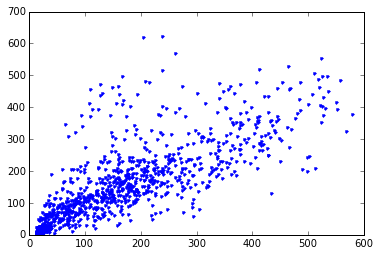

In [10]:
df_in = df_train[(df_train['year']==2011)]
df_in = df_in.drop(['year'], axis=1)
df_target = df_in
m1 = ann_train(df_in,df_target,arch,iterations)
print m1['fit']

df_test_test = df_test.drop(['holiday','workingday','weather','season'],axis = 1)
df_test_test['month'] = pd.DatetimeIndex(df_test_test.datetime).month
df_test_test['day'] = pd.DatetimeIndex(df_test_test.datetime).dayofweek
df_test_test['hour'] = pd.DatetimeIndex(df_test_test.datetime).hour
df_test_test['year'] = pd.DatetimeIndex(df_test_test.datetime).year
df_test_test = df_test_test.drop(['datetime'],axis = 1)

df_test_test = df_test_test[df_test_test['year']==2011]
df_test_test = df_test_test.drop(['year'],axis = 1)

out1 = m1['ann1'].predict(preprocessing.scale(df_test_test))
out2 = m1['ann2'].predict(preprocessing.scale(df_test_test))
out3 = m1['ann3'].predict(preprocessing.scale(df_test_test))
outm1 = out1 + out2
outm1 = outm1.astype(int)
outm1[outm1<0] = 0

0.945029854485


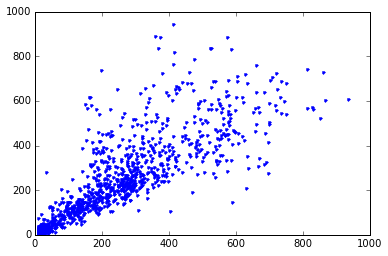

In [11]:
df_in = df_train[(df_train['year']==2012)]
df_in = df_in.drop(['year'], axis=1)
df_target = df_in
m2 = ann_train(df_in,df_target,arch,iterations)
print m2['fit']

df_test_test = df_test.drop(['holiday','workingday','weather','season'],axis = 1)
df_test_test['month'] = pd.DatetimeIndex(df_test_test.datetime).month
df_test_test['day'] = pd.DatetimeIndex(df_test_test.datetime).dayofweek
df_test_test['hour'] = pd.DatetimeIndex(df_test_test.datetime).hour
df_test_test['year'] = pd.DatetimeIndex(df_test_test.datetime).year
df_test_test = df_test_test.drop(['datetime'],axis = 1)

df_test_test = df_test_test[df_test_test['year']==2012]
df_test_test = df_test_test.drop(['year'],axis = 1)

out1 = m2['ann1'].predict(preprocessing.scale(df_test_test))
out2 = m2['ann2'].predict(preprocessing.scale(df_test_test))
out3 = m2['ann3'].predict(preprocessing.scale(df_test_test))
outm2 = out1 + out2
outm2 = outm2.astype(int)
outm2[outm2<0] = 0

In [13]:
out = np.append(np.array(outm1),(np.array(outm2)))
pred = pd.DataFrame({'datetime': df_test['datetime'],'count': out})
pred = pred[['datetime','count']]

In [70]:
pred.to_csv("pred.csv", index = False)

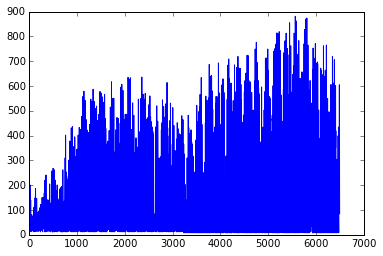

In [14]:
plt.plot(out)

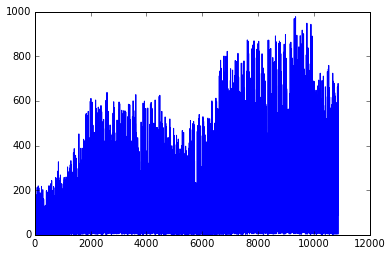

In [15]:
plt.plot(df_train['count'])

In [ ]:
plt.plot(target-pred_test)

In [ ]:
#df_test_test = df_test
df_test_test = df_test.drop(['holiday','workingday','weather','season'],axis = 1)
df_test_test['month'] = pd.DatetimeIndex(df_test_test.datetime).month
df_test_test['day'] = pd.DatetimeIndex(df_test_test.datetime).dayofweek
df_test_test['hour'] = pd.DatetimeIndex(df_test_test.datetime).hour
df_test_test = df_test_test.drop(['datetime'],axis = 1)

In [ ]:
out1 = ann1.predict(preprocessing.scale(df_test_test))
out2 = ann2.predict(preprocessing.scale(df_test_test))
out3 = ann3.predict(preprocessing.scale(df_test_test))
out = out1 + out2

#out = out3

In [ ]:
out = out.astype(int)
out[out<0] = 0

In [ ]:
pred = pd.DataFrame({'datetime': df_test['datetime'],'count': out})
pred = pred[['datetime','count']]

In [ ]:
pred.to_csv("pred.csv", index = False)

In [ ]:
plt.plot(out1,out2,'.')

In [ ]:
#plt.plot(out,out3,'.')

In [ ]:
plt.plot(out,'.')

In [ ]:
plt.plot(df_target_strip['casual'],ann1.predict(preprocessing.scale(df_train_strip)) ,'.')
plt.show()
plt.plot(df_target_strip['registered'],ann2.predict(preprocessing.scale(df_train_strip)) ,'.')

In [ ]:
plt.plot(ann1.predict(preprocessing.scale(df_train_strip)) ,'.')
plt.show()
plt.plot(ann2.predict(preprocessing.scale(df_train_strip)) ,'.')

In [33]:
l1 = 0
l2 = l1 +  len(df_target_strip['count'])
a = df_target_strip['count'] [l1:l2]
b = ( ann1.predict(preprocessing.scale(df_train_strip)) 
    + ann2.predict(preprocessing.scale(df_train_strip))
    )[l1:l2]
b = b.astype(int)
b[b<0]=0
c = ann3.predict(preprocessing.scale(df_train_strip)) [l1:l2]
c = c.astype(int)
c = np.array(c)
c[c<0]=0
plt.plot(range(len(a)),a,range(len(b)),b,range(len(c)),c)

NameError: name 'df_target_strip' is not defined

In [ ]:
rmsle(a,b)

In [ ]:
rmsle(a,c)